# Import

In [50]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import io
from PIL import Image
import PIL
import matplotlib.pyplot as plt

In [52]:
path_root = "/content/drive/MyDrive/Colab Notebooks/dataset/Face"
path_dataset_root = "/content/drive/MyDrive/Colab Notebooks/dataset/Face/Dataset_JPG"
os.listdir(path_root)

['Training', 'Testing', 'Dataset_JPG', 'facenet_keras.h5']

# Chuyển đuôi file pgm -> jpg

In [53]:
# # Tập train
# for s in range(1,41):
#     for i in range(1,10):
#         img = PIL.Image.open(path_root+"/Training/s{}/{}.pgm".format(s,i))
#         path = path_dataset_root+"/Train/s{}/".format(s)
#         # Tạo folder để lưu tập JPG
#         if not os.path.exists(path):
#           os.makedirs(path)
#         img.save(path+"{}.jpg".format(i))

In [54]:
# # Tập test
# for s in range(1,41):
#    imgTest = PIL.Image.open(path_root+"/Testing/s{}/{}.pgm".format(s,s))
#    path = path_dataset_root+"/Test/s{}/".format(s)
#    # Tạo folder để lưu tập JPG
#    if not os.path.exists(path):
#      os.makedirs(path)
#      imgTest.save(path+"{}.jpg".format(s,s))

# Define path datasetdataset

In [55]:
path_dataset_root = "/content/drive/MyDrive/Colab Notebooks/dataset/Face/Dataset_JPG"
path_dataset_train = "/content/drive/MyDrive/Colab Notebooks/dataset/Face/Dataset_JPG/Train"
path_dataset_test = "/content/drive/MyDrive/Colab Notebooks/dataset/Face/Dataset_JPG/Test"

# Load image with Keras

In [56]:
import tensorflow as tf
import  tensorflow.keras.layers as layers

In [57]:
# 1 lô có 32 hình
batch_size = 32
img_height = 180
img_width = 180

In [58]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_dataset_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 360 files belonging to 40 classes.
Using 288 files for training.


In [59]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path_dataset_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 360 files belonging to 40 classes.
Using 72 files for validation.


In [60]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  path_dataset_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 40 files belonging to 40 classes.


In [61]:
class_names = train_ds.class_names
print(class_names)

['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's4', 's40', 's5', 's6', 's7', 's8', 's9']


# Trực quan hóa dữ liệu

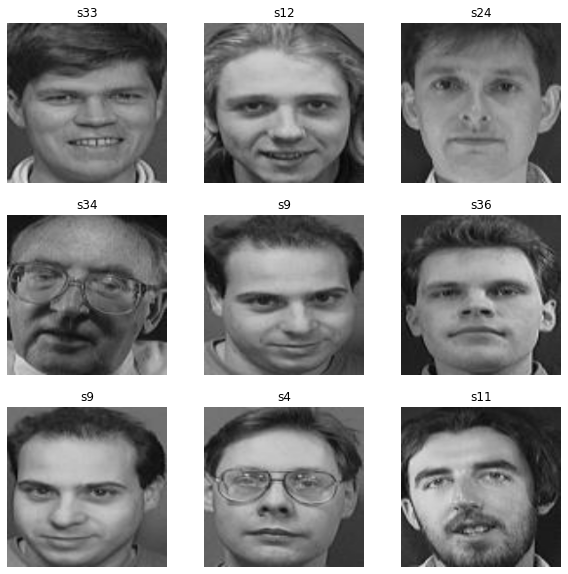

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



*   image_batch là một tenxơ của hình dạng (32, 180, 180, 3) .
*   Đây là một lô gồm 32 hình ảnh có hình dạng 180x180x3 (kích thước cuối cùng đề cập đến các kênh màu RGB). 
* label_batch là một tenxơ của hình (32,) , đây là những nhãn tương ứng với 32 hình ảnh.
* mỗi lô 32 ảnh, tương ứng có 12 lô


In [63]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  # print(labels_batch.shape)
  # break
len(train_ds)

(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)


9

# Chuẩn hóa dữ liệu
* Giá trị kênh RGB nằm trong phạm vi [0, 255] . Điều này không lý tưởng cho mạng nơ-ron
*chuẩn hóa các giá trị nằm trong phạm vi [0, 1] bằng cách sử dụng tf.keras.layers.Rescaling

In [64]:
normalization_layer =layers.Rescaling(1./255)

In [65]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0031757338 0.81355125


# Model

Mô hình Tuần tự bao gồm ba khối tích chập ( tf.keras.layers.Conv2D ) với một lớp tổng hợp tối đa ( tf.keras.layers.MaxPooling2D ) trong mỗi khối. Có một lớp được kết nối đầy đủ ( tf.keras.layers.Dense ) với 128 đơn vị trên cùng được kích hoạt bởi chức năng kích hoạt ReLU ( 'relu' ).
*   layers.MaxPooling2D() giảm param nhưng vẫn giữ đặc trưngtrưng
* Conv2D là convolution dùng để lấy feature từ ảnh với các tham số :
filters : số filter của convolution
kernel_size : kích thước window search trên ảnh
strides : số bước nhảy trên ảnh
activation : chọn activation như linear, softmax, relu, tanh, sigmoid. Đặc điểm mỗi hàm các bạn có thể search thêm để biết cụ thể nó ntn.
padding : có thể là "valid" hoặc "same". Với same thì có nghĩa là padding =1.

In [75]:
num_classes = 40

model = tf.keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.summary()
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 64)       

In [76]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
9/9 [==============================] - 2s 97ms/step - loss: 3.9054 - accuracy: 0.0243 - val_loss: 3.6982 - val_accuracy: 0.0278
Epoch 2/15
9/9 [==============================] - 1s 71ms/step - loss: 3.6466 - accuracy: 0.0729 - val_loss: 3.6445 - val_accuracy: 0.0972
Epoch 3/15
9/9 [==============================] - 1s 70ms/step - loss: 3.5038 - accuracy: 0.1840 - val_loss: 3.5435 - val_accuracy: 0.0833
Epoch 4/15
9/9 [==============================] - 1s 69ms/step - loss: 3.1203 - accuracy: 0.2188 - val_loss: 3.0702 - val_accuracy: 0.2083
Epoch 5/15
9/9 [==============================] - 1s 70ms/step - loss: 2.2429 - accuracy: 0.4444 - val_loss: 2.4191 - val_accuracy: 0.3750
Epoch 6/15
9/9 [==============================] - 1s 69ms/step - loss: 1.2727 - accuracy: 0.7326 - val_loss: 1.3909 - val_accuracy: 0.5833
Epoch 7/15
9/9 [==============================] - 1s 72ms/step - loss: 0.4546 - accuracy: 0.9028 - val_loss: 1.2415 - val_accuracy: 0.6111
Epoch 8/15
9/9 [===========

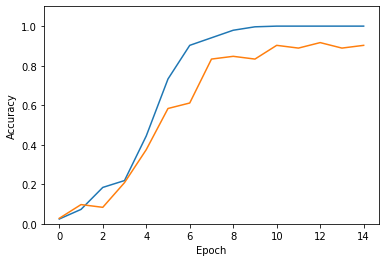

In [77]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])

test_loss, test_acc = model.evaluate(test_ds, verbose=epochs)

In [78]:
test_acc

0.949999988079071

In [70]:
img = tf.keras.utils.load_img(
     path_dataset_test+"/s3/3.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to s3 with a 52.83 percent confidence.


In [79]:
path_dataset_root

'/content/drive/MyDrive/Colab Notebooks/dataset/Face/Dataset_JPG'

In [84]:
tf.keras.models.save_model(model,path_dataset_root+"/Model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/dataset/Face/Dataset_JPG/Model/assets
